In [4]:
# Import necessary packages:
from scipy import io
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from scipy import stats

In [5]:
# Data reading function:
def read_spam_data():
    raw_data = io.loadmat('./DataSets/spamData.mat')
    # struct of raw_data is a dictionary:{'Xtrain':{}, 'ytrain':{}, 'Xtest':{}, 'ytest':{}}
    train_data = (raw_data['Xtrain'],raw_data['ytrain'])
    test_data = (raw_data['Xtest'],raw_data['ytest'])
    return train_data, test_data

In [6]:
# Declare objects in np.matrix data type to store the data
train_data, test_data = read_spam_data()
Xtrain = np.matrix(train_data[0])
ytrain = np.matrix(train_data[1])
Xtest = np.matrix(test_data[0])
ytest = np.matrix(test_data[1])
# data shape discovery:
print('Xtrain.shape: \t',Xtrain.shape)
print('ytrain.shape: \t',ytrain.shape)
print('Xtest.shape: \t',Xtest.shape)
print('ytest.shape: \t',ytest.shape)

Xtrain.shape: 	 (3065, 57)
ytrain.shape: 	 (3065, 1)
Xtest.shape: 	 (1536, 57)
ytest.shape: 	 (1536, 1)


We find the 3065 samples in traning set and 1536 samples in test set while each sample has 57 features.

In [7]:
# Data transformation functions
# function1: log
def transform_log(x):
    return np.log(x + 0.1)

# function2: binary
def transform_binary(x):
    # return 1 in int 32 when x>0
    return (x > 0).astype(np.int32)

# function3: standardlize
def transform_standard(x):
    return preprocessing.scale(x, axis=0)

# encapsulation
transform_functions = [transform_log,transform_binary,transform_standard]

Then for each version of the data,implement spam classiﬁcation using logistic regression and naive Bayes method, respectively.

In [8]:
# Fix the random seed for debug
np.random.seed(0)

For 8.1:
1. The LogisticRegression Class (without regularization) and L2_LogisticRegression (with L2 regularization) are both constructed.
2. The CV function is defined.
3. We try the lamda from a specific range for each of the transfer function to find the best lamda.
4. We use the chosen lamda to train the models with whole dataset to calculate the final mean error rate.

Model Converged at Iteration  175
Accuracy: 0.9036458333333334


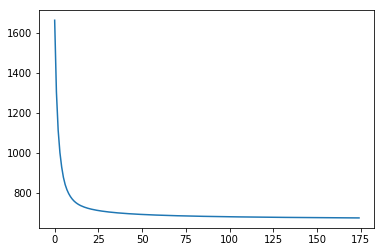

In [9]:
# LogisticRegression Class: without regularization
class LogisticRegression:
    
    # data field:
    Xtrain = np.matrix([])
    ytrain = np.matrix([])
    Xtest = np.matrix([])
    ytest = np.matrix([])
    W = np.matrix([])
    b = 0                     # we get rid of the bias here
    loss_history = []
    
    
    def __init__(self,Xtrain,ytrain,Xtest,ytest,trans_f):
        self.trans_f = trans_f
        self.Xtrain = trans_f(Xtrain)
        self.ytrain = ytrain.copy()
        self.Xtest = trans_f(Xtest)
        self.ytest = ytest.copy()
        self.W = (np.random.rand(Xtrain.shape[1],1)-0.5)*2     # keep the W unbiased
        loss_history = []
        
    def sigmoid(self, z):
        return 1.0/(1.0+np.exp(-z))
    
    def LogLoss(self):
        NLL = 0
        for i in range(len(self.ytrain)):
            z_i = self.Xtrain[i].dot(self.W) + self.b
            a_i = self.sigmoid(z_i)
            y_i = self.ytrain[i]
            if a_i == 0 or a_i == 1: continue
            NLL_i = - int(y_i)*np.log(a_i) - (1-int(y_i))*np.log(1-a_i)
            NLL += NLL_i
        return NLL
    
    def d_L_d_w(self):
        return self.Xtrain.T.dot(self.sigmoid(self.Xtrain.dot(self.W))-self.ytrain)
    
    def train(self):
        self.loss_history = []
        for i in range(3000):
            if self.trans_f == transform_functions[0]:
                self.W -= 0.0005*self.d_L_d_w()
            else:
                self.W -= 0.001*self.d_L_d_w()
            lossi = float(self.LogLoss())
            self.loss_history.append(lossi)
            if(len(self.loss_history)>=2 and abs(lossi-self.loss_history[-2])<= 0.05):
#                 print('Model Converged at Iteration',str(i))
                break
        if i == 3000 :print('Model Didn\'t Converge in 3000 Iterations' )
        return self.loss_history[-1]             # return the final loss
    
    def forward(self, X):
        return self.sigmoid(X.dot(self.W));
    
    def test(self):
        y_ = (self.forward(self.Xtest)>0.5).astype(int)
        correct_count = 0
        for i in range(len(self.ytest)):
            if y_[i] == self.ytest[i]: 
                correct_count += 1
        return correct_count/len(y_)

# class example for stnd
a = LogisticRegression(Xtrain, ytrain, Xtest, ytest,transform_functions[2])
a.train()
print('Model Converged at Iteration ',len(a.loss_history))
plt.plot(list(range(len(a.loss_history))),a.loss_history)
print('Accuracy:',a.test())

Model Converged at Iteration  110
Accuracy: 0.9088541666666666


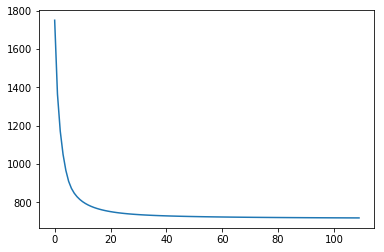

In [10]:
# L2_LogisticRegression Class: with L2 regularization
class L2_LogisticRegression(LogisticRegression):
    
    # we keep all data fields of LogisticRegression, and add:
    lamda = 0
    
    # rewrite the initialize function
    def __init__(self,Xtrain,ytrain,Xtest,ytest,trans_f, lamda):
        LogisticRegression.__init__(self,Xtrain,ytrain,Xtest,ytest,trans_f)
        self.lamda = lamda
    
    # rewrite g(w):
    def d_L_d_w(self):
        return (self.Xtrain.T.dot(self.sigmoid(self.Xtrain.dot(self.W))-self.ytrain) + self.lamda*self.W )
    
    # rewrite E(w):
    def LogLoss(self):
        NLL = 0
        for i in range(len(self.ytrain)):
            z_i = self.Xtrain[i].dot(self.W) + self.b
            a_i = self.sigmoid(z_i)
            y_i = self.ytrain[i]
            if a_i == 0 or a_i == 1: continue
            NLL_i = - int(y_i)*np.log(a_i) - (1-int(y_i))*np.log(1-a_i)
            NLL += NLL_i
        NLL += self.lamda * float(self.W.T.dot(self.W))
        return NLL
    
    # keep the train()
    
    # keep the forward()
    
    # keep the test()

# class example for log
a2 = L2_LogisticRegression(Xtrain, ytrain, Xtest, ytest,transform_functions[2],2)
a2.train()
print('Model Converged at Iteration ',len(a2.loss_history))
plt.plot(list(range(len(a2.loss_history))),a2.loss_history)
print('Accuracy:',a2.test())

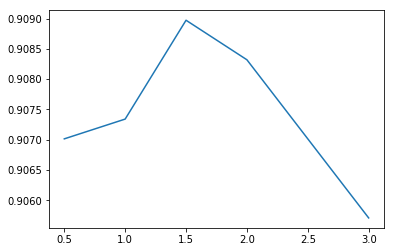

In [254]:
# Use 5-fold CV to test the best lamda for L2 Logistic Regression
def FindLamda(Xtrain, ytrain, LamdaList, fold=5, transferFunction = transform_functions[2]):
    
    # randomly split the Xtrain into 5 subsets and split the ytrain:
    index_remain = list(range(Xtrain.shape[0]))
    subindex_list = []
    for i in range(fold):
        subindex = np.random.choice(index_remain, int(Xtrain.shape[0]//fold), replace=False);
        index_remain = [ele for ele in index_remain if ele not in subindex]
        subindex_list.append(list(subindex))
    results = []
    bestAccuracy = 0
    bestLamda = 0
    for i in range(len(LamdaList)):
        lamda = LamdaList[i]
        performance_sum = 0
        for j in range(fold):
            Xvalidation_index = subindex_list[j]
            Xtrain_remain_index = []
            for k in range(fold):
                if k != j:
                    Xtrain_remain_index = Xtrain_remain_index + subindex_list[k]
            Xvalidation = Xtrain[Xvalidation_index]
            yvalidation = ytrain[Xvalidation_index]
            Xtrain_remain = Xtrain[Xtrain_remain_index]
            ytrain_remain = ytrain[Xtrain_remain_index]
            model = L2_LogisticRegression(Xtrain_remain, ytrain_remain, Xvalidation, yvalidation, transferFunction, lamda)
            model.train()
            accuracy = model.test()
            performance_sum += accuracy
        accuracy_mean = performance_sum/fold
        results.append(accuracy_mean)
        if accuracy_mean>bestAccuracy:
            bestLamda = lamda
            bestAccuracy = accuracy_mean
    cache = [LamdaList,results]
    best = [bestLamda, bestAccuracy]
    return cache, best

# example
cache,best = FindLamda(Xtrain, ytrain, [0.5,1,1.5,2,2.5,3]);
plt.plot(cache[0], cache[1])

Ps: Do not recommand to run the code since takes extremely long time...

In [288]:
# Select the lamda for transfer function: log
cache1, best1 = FindLamda(Xtrain, ytrain, [0.5,1,1.5,2,2.5,3], 5, transform_functions[0]); # log

In [256]:
# Select the lamda for transfer function: binary
cache2, best2 = FindLamda(Xtrain, ytrain, [0.5,1,1.5,2,2.5,3], 5, transform_functions[1]); # binary

In [324]:
# Select the lamda for transfer function: stnd has been calculated in example already
cache3, best3 = cache,best

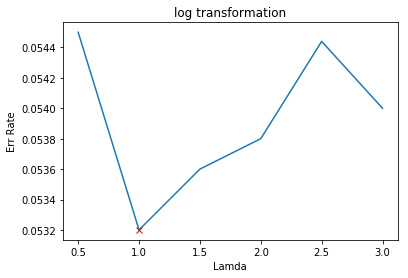

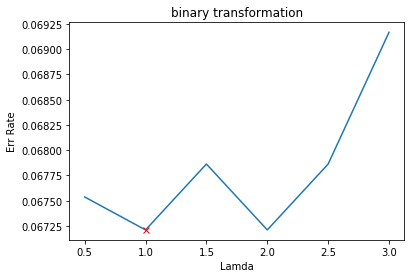

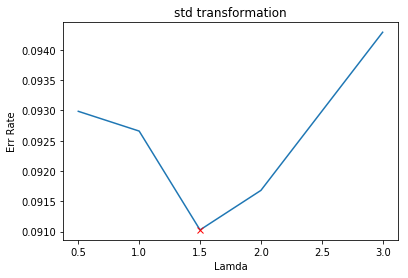

In [450]:
# Plot for lamda selection with different transfer function
fig1 = plt.figure()
plt.plot(cache1[0],[1-ele for ele in cache1[1]])
plt.plot(best1[0], 1-best1[1], 'rx')
plt.title('log transformation')
plt.xlabel('Lamda')
plt.ylabel('Err Rate')
plt.show()
plt.plot(cache2[0],[1-ele for ele in cache2[1]])
plt.plot(best2[0], 1-best2[1], 'rx')
plt.title('binary transformation')
plt.xlabel('Lamda')
plt.ylabel('Err Rate')
plt.show()
plt.plot(cache3[0],[1-ele for ele in cache3[1]])
plt.plot(best3[0], 1-best3[1], 'rx')
plt.title('std transformation')
plt.xlabel('Lamda')
plt.ylabel('Err Rate')
plt.show()

In [303]:
# Use lamda to train the log models
log_test_model = L2_LogisticRegression(Xtrain, ytrain, Xtest, ytest,transform_functions[0],best2[0])
log_train_model = L2_LogisticRegression(Xtrain, ytrain, Xtrain, ytrain,transform_functions[0],best2[0])
log_test_model.train()
log_train_model.train()
log_test_er = 1-log_test_model.test()
log_train_er = 1-log_train_model.test()

In [270]:
# Use lamda to train the binary models
binary_test_model = L2_LogisticRegression(Xtrain, ytrain, Xtest, ytest,transform_functions[1],best2[0])
binary_train_model = L2_LogisticRegression(Xtrain, ytrain, Xtrain, ytrain,transform_functions[1],best2[0])
binary_test_model.train()
binary_train_model.train()
binary_test_er = 1-binary_test_model.test()
binary_train_er = 1-binary_train_model.test()

In [272]:
# Use lamda to train the stnd models
stnd_test_model = L2_LogisticRegression(Xtrain, ytrain, Xtest, ytest,transform_functions[2],best3[0])
stnd_train_model = L2_LogisticRegression(Xtrain, ytrain, Xtrain, ytrain,transform_functions[2],best3[0])
stnd_test_model.train()
stnd_train_model.train()
stnd_test_er = 1-stnd_test_model.test()
stnd_train_er = 1-stnd_train_model.test()

In [316]:
# List the mean error rate on training ang test datasets for different transfer function
print('method \t train \t test')
print('stnd\t',round(stnd_train_er,3),'\t', round(stnd_test_er,3))
print('log\t',round(log_train_er,3),'\t', round(log_test_er,3))
print('binary\t',round(binary_train_er,3),'\t', round(binary_test_er,3))

method 	 train 	 test
stnd	 0.081 	 0.094
log	 0.052 	 0.077
binary	 0.065 	 0.072
